## UNET FROM SCRATCH

In [1]:
from google.colab import files, drive
drive.mount('/content/drive')
DB_PATH = '/content/drive/MyDrive/'

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CellularDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask



In [50]:
import torch
import torchvision
from torch.utils.data import DataLoader

def save_checkpoint(state, filename=os.path.join(DB_PATH,"my_checkpoint.pth.tar")):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    test_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CellularDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CellularDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )
    test_ds = CellularDataset(
        image_dir= TEST_IMG_DIR,
        mask_dir= TEST_IMG_DIR,
        transform=train_transform,
    )

    return train_loader, val_loader, train_ds, val_ds, test_ds

def check_accuracy(loader, model,loss_fn, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    dice_score2 = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = model(x)
            val_loss = loss_fn(preds, y)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score2 += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

            preds = preds.contiguous().view(preds.size(0), -1)
            trues = y.contiguous().view(y.size(0), -1)

            intersection = (preds * trues).sum(1)
            dice_score = (2. * intersection + 1e-8) / (preds.sum(1) + trues.sum(1) + 1e-8)


    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score.mean()}")
    print(f"Dice score over lenght loader: {dice_score.mean()/len(loader)}")
    print(f"Dice score 2 over lenght loader: {dice_score2/len(loader)}")

    model.train()
    return val_loss.item()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()



In [45]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 60
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = os.path.join(DB_PATH,"image_processed/train_img/")
TRAIN_MASK_DIR = os.path.join(DB_PATH,"image_processed/train_mask/")
VAL_IMG_DIR = os.path.join(DB_PATH,"image_processed/val_img/")
VAL_MASK_DIR = os.path.join(DB_PATH,"image_processed/val_mask/")
TEST_IMG_DIR = os.path.join(DB_PATH,"image_processed/test/")
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)
        targets = targets/255

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    return loss.item()

In [6]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.CLAHE(clip_limit=2),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)


In [46]:

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader, train_ds, val_ds, test_ds = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    TEST_IMG_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
)

if LOAD_MODEL:
    #load_checkpoint(torch.load(os.path.join(DB_PATH,"my_checkpoint.pth.tar"), map_location='cpu'), model)
    load_checkpoint(torch.load(os.path.join(DB_PATH,"my_checkpoint.pth.tar")), model)

loss_train = []
loss_val = []

#check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    loss_train.append(train_fn(train_loader, model, optimizer, loss_fn, scaler))

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)
    # print epoch
    print(f"Epoch n: {epoch + 1}/{NUM_EPOCHS}")
    # check accuracy
    loss_val.append(check_accuracy(val_loader, model,loss_fn, device=DEVICE))

    # print some examples to a folder
#    save_predictions_as_imgs(
#        val_loader, model, folder=os.path.join(DB_PATH,"saved_images/"), device=DEVICE
#    )


=> Loading checkpoint


100%|██████████| 37/37 [00:15<00:00,  2.46it/s, loss=0.353]


=> Saving checkpoint
Epoch n: 0/60
Got 4361301/5111808 with acc 85.32
Dice score: 0.22302061319351196
Dice score over lenght loader: 0.04460412263870239
Dice score 2 over lenght loader: 0.4607844054698944


100%|██████████| 37/37 [00:15<00:00,  2.39it/s, loss=0.344]


=> Saving checkpoint
Epoch n: 1/60
Got 4398413/5111808 with acc 86.04
Dice score: 0.4786381125450134
Dice score over lenght loader: 0.09572762250900269
Dice score 2 over lenght loader: 0.8564150929450989


100%|██████████| 37/37 [00:15<00:00,  2.36it/s, loss=0.312]


=> Saving checkpoint
Epoch n: 2/60
Got 4360973/5111808 with acc 85.31
Dice score: 0.2846033275127411
Dice score over lenght loader: 0.05692066624760628
Dice score 2 over lenght loader: 0.7758809924125671


100%|██████████| 37/37 [00:15<00:00,  2.44it/s, loss=0.279]


=> Saving checkpoint
Epoch n: 3/60
Got 4340590/5111808 with acc 84.91
Dice score: 0.154164656996727
Dice score over lenght loader: 0.030832931399345398
Dice score 2 over lenght loader: 0.6925037503242493


100%|██████████| 37/37 [00:15<00:00,  2.44it/s, loss=0.274]


=> Saving checkpoint
Epoch n: 4/60
Got 4362059/5111808 with acc 85.33
Dice score: 0.4085544943809509
Dice score over lenght loader: 0.08171089738607407
Dice score 2 over lenght loader: 0.9632207155227661


100%|██████████| 37/37 [00:15<00:00,  2.37it/s, loss=0.242]


=> Saving checkpoint
Epoch n: 5/60
Got 4354071/5111808 with acc 85.18
Dice score: 0.3030090034008026
Dice score over lenght loader: 0.06060180068016052
Dice score 2 over lenght loader: 0.9623298645019531


100%|██████████| 37/37 [00:15<00:00,  2.44it/s, loss=0.255]


=> Saving checkpoint
Epoch n: 6/60
Got 4367888/5111808 with acc 85.45
Dice score: 0.4095233678817749
Dice score over lenght loader: 0.08190467208623886
Dice score 2 over lenght loader: 1.0209176540374756


100%|██████████| 37/37 [00:15<00:00,  2.38it/s, loss=0.21]


=> Saving checkpoint
Epoch n: 7/60
Got 4365391/5111808 with acc 85.40
Dice score: 0.3571052849292755
Dice score over lenght loader: 0.0714210569858551
Dice score 2 over lenght loader: 0.9761375784873962


100%|██████████| 37/37 [00:15<00:00,  2.43it/s, loss=0.223]


=> Saving checkpoint
Epoch n: 8/60
Got 4367534/5111808 with acc 85.44
Dice score: 0.36765414476394653
Dice score over lenght loader: 0.07353083044290543
Dice score 2 over lenght loader: 0.9070860147476196


100%|██████████| 37/37 [00:15<00:00,  2.38it/s, loss=0.22]


=> Saving checkpoint
Epoch n: 9/60
Got 4344303/5111808 with acc 84.99
Dice score: 0.2470822036266327
Dice score over lenght loader: 0.0494164414703846
Dice score 2 over lenght loader: 0.9518739581108093


100%|██████████| 37/37 [00:15<00:00,  2.38it/s, loss=0.192]


=> Saving checkpoint
Epoch n: 10/60
Got 4371070/5111808 with acc 85.51
Dice score: 0.4007679522037506
Dice score over lenght loader: 0.08015359193086624
Dice score 2 over lenght loader: 1.031141757965088


100%|██████████| 37/37 [00:15<00:00,  2.36it/s, loss=0.188]


=> Saving checkpoint
Epoch n: 11/60
Got 4377299/5111808 with acc 85.63
Dice score: 0.527485728263855
Dice score over lenght loader: 0.10549714416265488
Dice score 2 over lenght loader: 1.1467901468276978


100%|██████████| 37/37 [00:15<00:00,  2.40it/s, loss=0.161]


=> Saving checkpoint
Epoch n: 12/60
Got 4351823/5111808 with acc 85.13
Dice score: 0.31608977913856506
Dice score over lenght loader: 0.06321796029806137
Dice score 2 over lenght loader: 1.0398733615875244


100%|██████████| 37/37 [00:15<00:00,  2.40it/s, loss=0.16]


=> Saving checkpoint
Epoch n: 13/60
Got 4374848/5111808 with acc 85.58
Dice score: 0.5797104835510254
Dice score over lenght loader: 0.1159420982003212
Dice score 2 over lenght loader: 1.0989048480987549


100%|██████████| 37/37 [00:15<00:00,  2.35it/s, loss=0.184]


=> Saving checkpoint
Epoch n: 14/60
Got 4347385/5111808 with acc 85.05
Dice score: 0.2560107111930847
Dice score over lenght loader: 0.05120214447379112
Dice score 2 over lenght loader: 0.901553750038147


100%|██████████| 37/37 [00:15<00:00,  2.40it/s, loss=0.153]


=> Saving checkpoint
Epoch n: 15/60
Got 4350503/5111808 with acc 85.11
Dice score: 0.3280661106109619
Dice score over lenght loader: 0.06561322510242462
Dice score 2 over lenght loader: 0.9580133557319641


100%|██████████| 37/37 [00:15<00:00,  2.44it/s, loss=0.147]


=> Saving checkpoint
Epoch n: 16/60
Got 4357163/5111808 with acc 85.24
Dice score: 0.4509161114692688
Dice score over lenght loader: 0.09018322080373764
Dice score 2 over lenght loader: 1.1107207536697388


100%|██████████| 37/37 [00:15<00:00,  2.38it/s, loss=0.135]


=> Saving checkpoint
Epoch n: 17/60
Got 4353166/5111808 with acc 85.16
Dice score: 0.5305831432342529
Dice score over lenght loader: 0.1061166301369667
Dice score 2 over lenght loader: 1.1502597332000732


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.15]


=> Saving checkpoint
Epoch n: 18/60
Got 4342199/5111808 with acc 84.94
Dice score: 0.3787814676761627
Dice score over lenght loader: 0.07575629651546478
Dice score 2 over lenght loader: 1.0557562112808228


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.127]


=> Saving checkpoint
Epoch n: 19/60
Got 4341210/5111808 with acc 84.93
Dice score: 0.38341590762138367
Dice score over lenght loader: 0.07668318599462509
Dice score 2 over lenght loader: 1.1054232120513916


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.154]


=> Saving checkpoint
Epoch n: 20/60
Got 4424108/5111808 with acc 86.55
Dice score: 0.7044196724891663
Dice score over lenght loader: 0.1408839374780655
Dice score 2 over lenght loader: 1.2638145685195923


100%|██████████| 37/37 [00:15<00:00,  2.37it/s, loss=0.119]


=> Saving checkpoint
Epoch n: 21/60
Got 4339402/5111808 with acc 84.89
Dice score: 0.1630449742078781
Dice score over lenght loader: 0.0326089970767498
Dice score 2 over lenght loader: 0.8690710067749023


100%|██████████| 37/37 [00:15<00:00,  2.40it/s, loss=0.112]


=> Saving checkpoint
Epoch n: 22/60
Got 4339698/5111808 with acc 84.90
Dice score: 0.30414900183677673
Dice score over lenght loader: 0.06082979962229729
Dice score 2 over lenght loader: 0.8890113234519958


100%|██████████| 37/37 [00:15<00:00,  2.40it/s, loss=0.114]


=> Saving checkpoint
Epoch n: 23/60
Got 4376518/5111808 with acc 85.62
Dice score: 0.6368153095245361
Dice score over lenght loader: 0.12736307084560394
Dice score 2 over lenght loader: 1.2564326524734497


100%|██████████| 37/37 [00:15<00:00,  2.40it/s, loss=0.0954]


=> Saving checkpoint
Epoch n: 24/60
Got 4338953/5111808 with acc 84.88
Dice score: 0.35189053416252136
Dice score over lenght loader: 0.07037810981273651
Dice score 2 over lenght loader: 1.0395954847335815


100%|██████████| 37/37 [00:15<00:00,  2.44it/s, loss=0.108]


=> Saving checkpoint
Epoch n: 25/60
Got 4340315/5111808 with acc 84.91
Dice score: 0.2651931643486023
Dice score over lenght loader: 0.05303863435983658
Dice score 2 over lenght loader: 1.016438603401184


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.0857]


=> Saving checkpoint
Epoch n: 26/60
Got 4456595/5111808 with acc 87.18
Dice score: 0.7188349366188049
Dice score over lenght loader: 0.14376698434352875
Dice score 2 over lenght loader: 1.0265192985534668


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.0917]


=> Saving checkpoint
Epoch n: 27/60
Got 4406419/5111808 with acc 86.20
Dice score: 0.5383127927780151
Dice score over lenght loader: 0.10766255855560303
Dice score 2 over lenght loader: 1.044175386428833


100%|██████████| 37/37 [00:15<00:00,  2.45it/s, loss=0.117]


=> Saving checkpoint
Epoch n: 28/60
Got 4348324/5111808 with acc 85.06
Dice score: 0.42223283648490906
Dice score over lenght loader: 0.08444657176733017
Dice score 2 over lenght loader: 1.1554195880889893


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.0789]


=> Saving checkpoint
Epoch n: 29/60
Got 4343148/5111808 with acc 84.96
Dice score: 0.4732265770435333
Dice score over lenght loader: 0.09464531391859055
Dice score 2 over lenght loader: 1.2110719680786133


100%|██████████| 37/37 [00:15<00:00,  2.43it/s, loss=0.0955]


=> Saving checkpoint
Epoch n: 30/60
Got 4347062/5111808 with acc 85.04
Dice score: 0.49044814705848694
Dice score over lenght loader: 0.09808962792158127
Dice score 2 over lenght loader: 1.2159531116485596


100%|██████████| 37/37 [00:15<00:00,  2.37it/s, loss=0.0772]


=> Saving checkpoint
Epoch n: 31/60
Got 4354491/5111808 with acc 85.18
Dice score: 0.4772750437259674
Dice score over lenght loader: 0.09545501321554184
Dice score 2 over lenght loader: 1.1790512800216675


100%|██████████| 37/37 [00:15<00:00,  2.39it/s, loss=0.0756]


=> Saving checkpoint
Epoch n: 32/60
Got 4341791/5111808 with acc 84.94
Dice score: 0.4747355878353119
Dice score over lenght loader: 0.09494712203741074
Dice score 2 over lenght loader: 1.2024401426315308


100%|██████████| 37/37 [00:15<00:00,  2.44it/s, loss=0.0591]


=> Saving checkpoint
Epoch n: 33/60
Got 4342336/5111808 with acc 84.95
Dice score: 0.4857785701751709
Dice score over lenght loader: 0.09715571254491806
Dice score 2 over lenght loader: 1.1939467191696167


100%|██████████| 37/37 [00:15<00:00,  2.43it/s, loss=0.0764]


=> Saving checkpoint
Epoch n: 34/60
Got 4359356/5111808 with acc 85.28
Dice score: 0.42741817235946655
Dice score over lenght loader: 0.08548363298177719
Dice score 2 over lenght loader: 1.156484842300415


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.0736]


=> Saving checkpoint
Epoch n: 35/60
Got 4399011/5111808 with acc 86.06
Dice score: 0.5727222561836243
Dice score over lenght loader: 0.11454445123672485
Dice score 2 over lenght loader: 1.1699646711349487


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.0866]


=> Saving checkpoint
Epoch n: 36/60
Got 4345106/5111808 with acc 85.00
Dice score: 0.4724258482456207
Dice score over lenght loader: 0.09448517113924026
Dice score 2 over lenght loader: 1.1960551738739014


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.0634]


=> Saving checkpoint
Epoch n: 37/60
Got 4343088/5111808 with acc 84.96
Dice score: 0.420539915561676
Dice score over lenght loader: 0.08410798758268356
Dice score 2 over lenght loader: 1.17471444606781


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.0744]


=> Saving checkpoint
Epoch n: 38/60
Got 4341680/5111808 with acc 84.93
Dice score: 0.3983629643917084
Dice score over lenght loader: 0.07967259734869003
Dice score 2 over lenght loader: 1.15478515625


100%|██████████| 37/37 [00:15<00:00,  2.44it/s, loss=0.0714]


=> Saving checkpoint
Epoch n: 39/60
Got 4343607/5111808 with acc 84.97
Dice score: 0.5010308027267456
Dice score over lenght loader: 0.100206159055233
Dice score 2 over lenght loader: 1.2466684579849243


100%|██████████| 37/37 [00:16<00:00,  2.24it/s, loss=0.0566]


=> Saving checkpoint
Epoch n: 40/60
Got 4342262/5111808 with acc 84.95
Dice score: 0.48200684785842896
Dice score over lenght loader: 0.09640137106180191
Dice score 2 over lenght loader: 1.2347313165664673


100%|██████████| 37/37 [00:15<00:00,  2.32it/s, loss=0.0598]


=> Saving checkpoint
Epoch n: 41/60
Got 4342848/5111808 with acc 84.96
Dice score: 0.5098743438720703
Dice score over lenght loader: 0.10197486728429794
Dice score 2 over lenght loader: 1.246355652809143


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.0621]


=> Saving checkpoint
Epoch n: 42/60
Got 4342029/5111808 with acc 84.94
Dice score: 0.5174617171287537
Dice score over lenght loader: 0.10349234193563461
Dice score 2 over lenght loader: 1.2532144784927368


100%|██████████| 37/37 [00:15<00:00,  2.39it/s, loss=0.0585]


=> Saving checkpoint
Epoch n: 43/60
Got 4342589/5111808 with acc 84.95
Dice score: 0.5003356337547302
Dice score over lenght loader: 0.1000671312212944
Dice score 2 over lenght loader: 1.231824278831482


100%|██████████| 37/37 [00:15<00:00,  2.45it/s, loss=0.0852]


=> Saving checkpoint
Epoch n: 44/60
Got 4344887/5111808 with acc 85.00
Dice score: 0.545616626739502
Dice score over lenght loader: 0.10912332683801651
Dice score 2 over lenght loader: 1.2943636178970337


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.0785]


=> Saving checkpoint
Epoch n: 45/60
Got 4342297/5111808 with acc 84.95
Dice score: 0.53056401014328
Dice score over lenght loader: 0.10611280053853989
Dice score 2 over lenght loader: 1.2858794927597046


100%|██████████| 37/37 [00:15<00:00,  2.43it/s, loss=0.0612]


=> Saving checkpoint
Epoch n: 46/60
Got 4346896/5111808 with acc 85.04
Dice score: 0.5270995497703552
Dice score over lenght loader: 0.10541991144418716
Dice score 2 over lenght loader: 1.2546557188034058


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.0657]


=> Saving checkpoint
Epoch n: 47/60
Got 4345232/5111808 with acc 85.00
Dice score: 0.5214199423789978
Dice score over lenght loader: 0.10428398847579956
Dice score 2 over lenght loader: 1.2740702629089355


100%|██████████| 37/37 [00:15<00:00,  2.43it/s, loss=0.0854]


=> Saving checkpoint
Epoch n: 48/60
Got 4341044/5111808 with acc 84.92
Dice score: 0.46707668900489807
Dice score over lenght loader: 0.09341534227132797
Dice score 2 over lenght loader: 1.2073547840118408


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.0528]


=> Saving checkpoint
Epoch n: 49/60
Got 4342123/5111808 with acc 84.94
Dice score: 0.522321879863739
Dice score over lenght loader: 0.10446437448263168
Dice score 2 over lenght loader: 1.270554542541504


100%|██████████| 37/37 [00:15<00:00,  2.45it/s, loss=0.0508]


=> Saving checkpoint
Epoch n: 50/60
Got 4341904/5111808 with acc 84.94
Dice score: 0.4962592124938965
Dice score over lenght loader: 0.09925184398889542
Dice score 2 over lenght loader: 1.23241126537323


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.0494]


=> Saving checkpoint
Epoch n: 51/60
Got 4342799/5111808 with acc 84.96
Dice score: 0.5191332101821899
Dice score over lenght loader: 0.10382664203643799
Dice score 2 over lenght loader: 1.2739719152450562


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.05]


=> Saving checkpoint
Epoch n: 52/60
Got 4342664/5111808 with acc 84.95
Dice score: 0.5018569231033325
Dice score over lenght loader: 0.10037138313055038
Dice score 2 over lenght loader: 1.256641149520874


100%|██████████| 37/37 [00:15<00:00,  2.43it/s, loss=0.0568]


=> Saving checkpoint
Epoch n: 53/60
Got 4343929/5111808 with acc 84.98
Dice score: 0.4100632071495056
Dice score over lenght loader: 0.08201264590024948
Dice score 2 over lenght loader: 1.2083395719528198


100%|██████████| 37/37 [00:15<00:00,  2.43it/s, loss=0.0549]


=> Saving checkpoint
Epoch n: 54/60
Got 4346631/5111808 with acc 85.03
Dice score: 0.5387740731239319
Dice score over lenght loader: 0.10775481909513474
Dice score 2 over lenght loader: 1.2908662557601929


100%|██████████| 37/37 [00:15<00:00,  2.42it/s, loss=0.0554]


=> Saving checkpoint
Epoch n: 55/60
Got 4358259/5111808 with acc 85.26
Dice score: 0.48068442940711975
Dice score over lenght loader: 0.09613689035177231
Dice score 2 over lenght loader: 1.2042683362960815


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.0721]


=> Saving checkpoint
Epoch n: 56/60
Got 4341595/5111808 with acc 84.93
Dice score: 0.5051311254501343
Dice score over lenght loader: 0.10102622956037521
Dice score 2 over lenght loader: 1.251062273979187


100%|██████████| 37/37 [00:15<00:00,  2.43it/s, loss=0.0405]


=> Saving checkpoint
Epoch n: 57/60
Got 4408960/5111808 with acc 86.25
Dice score: 0.7030684947967529
Dice score over lenght loader: 0.14061370491981506
Dice score 2 over lenght loader: 1.2330559492111206


100%|██████████| 37/37 [00:15<00:00,  2.40it/s, loss=0.0887]


=> Saving checkpoint
Epoch n: 58/60
Got 4362052/5111808 with acc 85.33
Dice score: 0.5354325771331787
Dice score over lenght loader: 0.10708651691675186
Dice score 2 over lenght loader: 1.2036000490188599


100%|██████████| 37/37 [00:15<00:00,  2.41it/s, loss=0.0794]


=> Saving checkpoint
Epoch n: 59/60
Got 4341295/5111808 with acc 84.93
Dice score: 0.5024391412734985
Dice score over lenght loader: 0.10048782825469971
Dice score 2 over lenght loader: 1.247169852256775


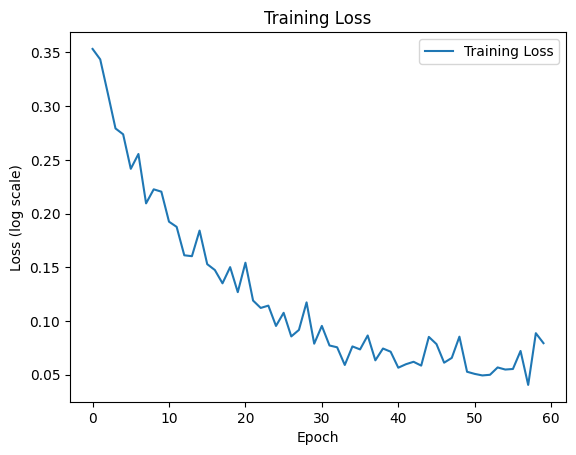

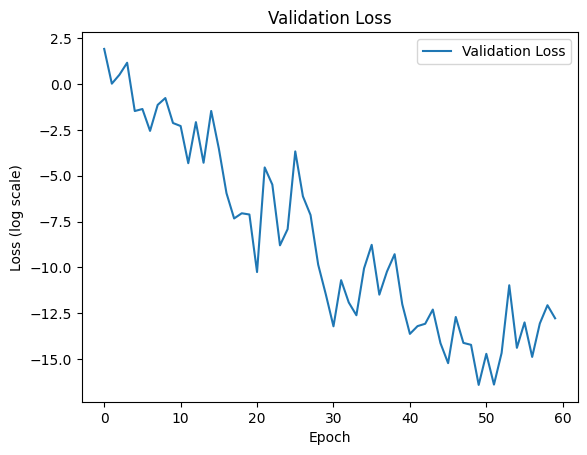

In [53]:
plt.figure()
plt.plot(loss_train, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()

# Validation Loss

#loss_val = [val.item() for val in loss_val]


plt.figure()
plt.plot(loss_val, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()


## immagine da cancellare dal train

In [ ]:
# 7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80

(tensor([[[0.0549, 0.0588, 0.0627,  ..., 0.6000, 0.5059, 0.3098],
         [0.0549, 0.0549, 0.0510,  ..., 0.5451, 0.5804, 0.4627],
         [0.0471, 0.0510, 0.0510,  ..., 0.5412, 0.5647, 0.5059],
         ...,
         [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0549, 0.0510],
         [0.0471, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0588],
         [0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0549, 0.0471]],

        [[0.0549, 0.0588, 0.0627,  ..., 0.6000, 0.5059, 0.3098],
         [0.0549, 0.0549, 0.0510,  ..., 0.5451, 0.5804, 0.4627],
         [0.0471, 0.0510, 0.0510,  ..., 0.5412, 0.5647, 0.5059],
         ...,
         [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0549, 0.0510],
         [0.0471, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0588],
         [0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0549, 0.0471]],

        [[0.0549, 0.0588, 0.0627,  ..., 0.6000, 0.5059, 0.3098],
         [0.0549, 0.0549, 0.0510,  ..., 0.5451, 0.5804, 0.4627],
         [0.0471, 0.0510, 0.0510,  ..., 0.5412, 0.5647, 0

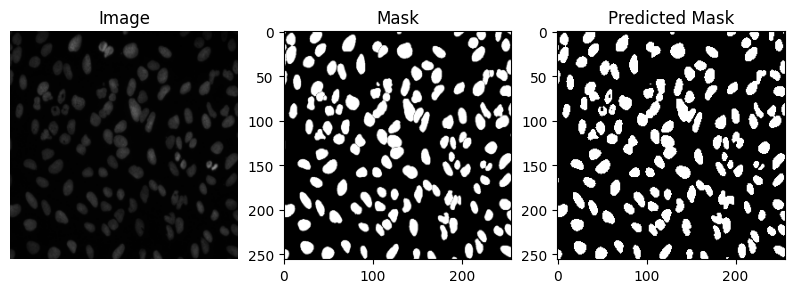

In [54]:
import random
import matplotlib.pyplot as plt

def predict(model, image):
    model.eval()
    image = image.to(DEVICE)
    out = model(image.float())
    #out = (out - out.min()) / (out.max() - out.min())
    return out

index = random.randint(0, len(val_ds)- 1)
# draw a random image from the validation set

image, mask = val_ds[index]
# print id of the image
print(val_ds[10])
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)

# predict the mask
predicted_mask = predict(model, image)
predicted_mask = predicted_mask.squeeze(0)
predicted_mask = (predicted_mask >0.5).float()

# plot the image, mask and predicted mask
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
plt.title("Predicted Mask")

plt.show()

## test set

tensor([[[-3.7212, -3.7765, -3.5734,  ..., -3.3322, -3.1422, -3.6022],
         [-3.8326, -3.5191, -3.6313,  ..., -3.5523, -3.3841, -3.1944],
         [-4.1148, -4.1629, -4.2742,  ..., -3.3502, -3.4714, -3.4172],
         ...,
         [-3.9901, -4.2536, -4.2135,  ..., -4.6293, -4.8761, -4.3655],
         [-3.8810, -4.2841, -4.3059,  ..., -4.7304, -4.7167, -3.9948],
         [-3.6441, -3.8419, -3.9956,  ..., -4.2201, -4.3712, -3.6315]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


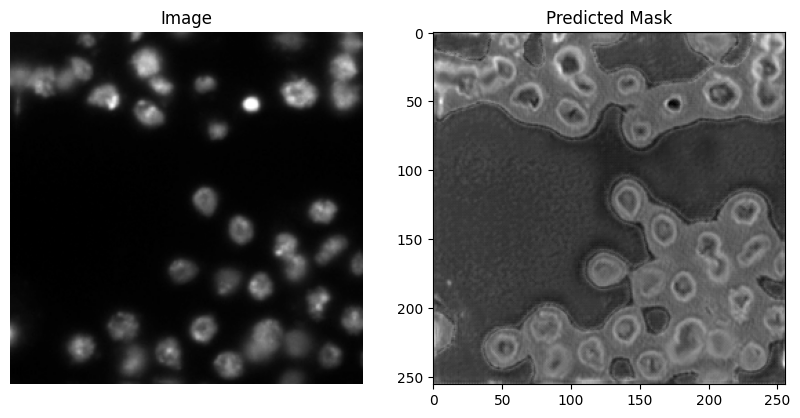

In [88]:
image = test_ds[0][0]
image = image.unsqueeze(0)
# print id of the image
#print(image)
predicted_mask = predict(model, image)

#predicted_mask = predicted_mask
predicted_mask = predicted_mask.squeeze(0)
#predicted_mask = predicted_mask / 255
#predicted_mask = torch.sigmoid(predicted_mask)
print(predicted_mask)
#predicted_mask = (predicted_mask >0.01).float()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
plt.title("Predicted Mask")

plt.show()

In [89]:
img_path = os.path.join(DB_PATH, 'image_processed/train_img/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')
mask_path = os.path.join(DB_PATH, 'image_processed/train_mask/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')
image = np.array(Image.open(img_path).convert("RGB"))
mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
mask[mask == 255.0] = 1.0

image= train_ds[0][0].unsqueeze(0)
predbis = predict(model, image)
print(predbis)



tensor([[[[-3.8821, -4.2610, -4.3034,  ..., -4.2300, -3.7298, -4.1110],
          [-4.0328, -4.1638, -4.2008,  ..., -4.4203, -3.7206, -3.8262],
          [-4.3813, -4.6561, -4.5778,  ..., -4.6629, -4.2788, -4.3370],
          ...,
          [-4.2371, -4.1268, -4.2532,  ..., -4.5545, -3.8803, -3.7020],
          [-3.7149, -3.8159, -3.9474,  ..., -3.8919, -3.2139, -3.3391],
          [-3.7735, -3.7355, -3.7815,  ..., -3.7278, -3.3656, -3.4138]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)
